In [105]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
import regex as re
import seaborn as sns
import folium
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
sns.set_style("whitegrid")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Importing Data

In [3]:
from urllib.request import HTTPError

def format_day_month(num):
    return '0' + str(num) if num < 10 else str(num)

def format_year(num):
    return str(num)[-2:]

def generate_url(date):
    '''
    This function generates and returns MTA turnstile data style url.
    '''
    y = format_year(date.year)
    m = format_day_month(date.month)
    d = format_day_month(date.day)
    return f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{y}{m}{d}.txt'

def import_mtadata(start, end):
    '''
    This function gets MTA turnstile data betwee a given start and end dates. 
    both start and end dates must be Saturdays to match turnstile data url's.
    '''
    assert pd.to_datetime(start).weekday() == 5, "Start must be a Saturday to match turnstile data"
    assert pd.to_datetime(start).weekday() == 5, "End must be a Saturday to match turnstile data"
    urls = list(map(generate_url, pd.date_range(start, end, freq="7D")))
    
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
            dfs.append(df)
        except HTTPError as err:
            if err.code == 404:
                continue
            else:
                raise err
    return pd.concat(dfs).reset_index()

In [16]:
def clean_data(df):
    '''
    This function takes a dataframe and cleans them.
    For column names - removes spaces & symbols, lowercase.
    converts datetime columns from string to dates.
    converts time column from string to time.
    '''
    try:
        df.columns = [col.strip() for col in df.columns]
        df.columns = [col.lower() for col in df.columns]
        df.columns = [re.sub('[^A-Za-z0-9_]+', '', col) for col in df.columns]
        mta_full['date'] = pd.to_datetime(mta_full['date'], format='%Y/%m/%d').dt.date
        mta_full['time'] = pd.to_datetime(mta_full['time'], format='%H:%M:%S').dt.time
        df = df.drop(['index'], axis=1)
    except Exception as e:
         print(e)
    return df

The gala is supposed to be held during summer (June / July / August) of 2020, so I figure the street campaign should happen at least 3 months ahead anywhere between Feb and March. So I focussed on ridership between Feb and March of the previous year, as well as to get an idea of how the ridership changed in the recent years, I looked at Jan 2019 and Jan 2020. 

In [9]:
mta_data_jan_mar_2019 = import_mtadata('1/5/2019', '3/30/2019')

In [7]:
mta_data_jan_2020 = import_mtadata('1/4/2020', '2/1/2020')

In [10]:
mta_full = pd.concat([mta_data_jan_mar_2019, mta_data_jan_2020], axis=0, ignore_index=True)

In [11]:
mta_clean = clean_data(mta_full)
mta_clean.head()

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,19:00:00,REGULAR,6889966,2336173


In [12]:
mta_clean.to_csv('mta_full.csv')

## Data Sanity Checks

In [17]:
mta_data = pd.read_csv('mta_full.csv', date_parser=True)
mta_clean = clean_data(mta_data)
mta_clean.head()

name 'mta_full' is not defined


,unnamed0,ca,unit,scp,station,linename,division,date,time,desc,entries,exits
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,03:00:00,REGULAR,6889287,2335920
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,07:00:00,REGULAR,6889299,2335936
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,11:00:00,REGULAR,6889364,2336038
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,15:00:00,REGULAR,6889605,2336101
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,19:00:00,REGULAR,6889966,2336173


In [18]:
mta_full = mta_clean.drop(columns='unnamed0')
type(mta_clean.loc[5, 'date'])

str

In [19]:
mta_full.isnull().sum()

ca          0
unit        0
scp         0
station     0
linename    0
division    0
date        0
time        0
desc        0
entries     0
exits       0
dtype: int64

No null values have been found for each column.

In [20]:
mta_full.station.nunique()

378

In [21]:
group = ["ca", "unit", "scp", "station", "date", "time"]
mta_full.groupby(group).last().reset_index().head(5)

,ca,unit,scp,station,date,time,linename,division,desc,entries,exits
0,A002,R051,02-00-00,59 ST,2018-12-29,03:00:00,NQR456W,BMT,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,2018-12-29,07:00:00,NQR456W,BMT,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,2018-12-29,11:00:00,NQR456W,BMT,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,2018-12-29,15:00:00,NQR456W,BMT,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,2018-12-29,19:00:00,NQR456W,BMT,REGULAR,6889966,2336173


from above, entries and exits are cumulative. we have to find the differential to have the number of turnstile entries / exits between each data entry.

In [22]:
group = ["ca", "unit", "scp", "station", "date"]
mta_full.groupby(group).count()

linename  division  time  desc  \
ca    unit scp      station       date                                         
A002  R051 02-00-00 59 ST         2018-12-29         6         6     6     6   
                                  2018-12-30         6         6     6     6   
                                  2018-12-31         6         6     6     6   
                                  2019-01-01         6         6     6     6   
                                  2019-01-02         6         6     6     6   
...                                                ...       ...   ...   ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT 2020-01-27         6         6     6     6   
                                  2020-01-28         6         6     6     6   
                                  2020-01-29         6         6     6     6   
                                  2020-01-30         6         6     6     6   
                                  2020-01-31         6         6     6     6   

                                              entries  exits  
ca    unit scp      station       date                        
A002  R051 02-00-00 59 ST         2018-12-29        6      6  
                                  2018-12-30        6      6  
                                  2018-12-31        6      6  
                                  2019-01-01        6      6  
                                  2019-01-02        6      6  
...                                               ...    ...  
TRAM2 R469 00-05-01 RIT-ROOSEVELT 2020-01-27        6      6  
                                  2020-01-28        6      6  
                                  2020-01-29        6      6  
                                  2020-01-30        6      6  
                                  2020-01-31        6      6  

[609388 rows x 6 columns]

For each day for a given station we see that there are anywhere between 6 and 12 data-entries logged by each turnstile. 12 seems very high. lets check on the times

In [23]:
unit_mask = (mta_full.ca=='TRAM2') & (mta_full.unit=='R469') & \
        (mta_full.scp=='00-05-01') & (mta_full.station=='RIT-ROOSEVELT') & \
        (mta_full.date==(pd.to_datetime('2019-12-28', format='%Y/%m/%d')))
roosevelt_unit = mta_full[unit_mask]
roosevelt_unit.sort_values('time').head(12)

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits


We can see that the entries are duplicated, so we can check for duplicate entries and eliminate them. 

In [24]:
group = ["ca", "unit", "scp", "station", "date", "time"]
mta_full['duplicates'] = mta_full.groupby(group)['entries'].transform('count')
mta_full.sort_values('duplicates', ascending=False)

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,duplicates
3442412,R514,R094,00-05-00,ASTORIA BLVD,NQW,BMT,2020-01-18,19:00:00,RECOVR AUD,16,0,2
2535401,N519,R461,00-03-01,B'WAY-LAFAYETTE,BDFQ6,IND,2019-03-25,05:00:00,REGULAR,18098217,18836635,2
2535408,N519,R461,00-03-01,B'WAY-LAFAYETTE,BDFQ6,IND,2019-03-25,17:00:00,RECOVR AUD,7784251,9508047,2
2535407,N519,R461,00-03-01,B'WAY-LAFAYETTE,BDFQ6,IND,2019-03-25,17:00:00,REGULAR,18098811,18838012,2
2535406,N519,R461,00-03-01,B'WAY-LAFAYETTE,BDFQ6,IND,2019-03-25,13:00:00,RECOVR AUD,7783771,9507495,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1222723,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-14,23:00:00,REGULAR,6285897,2656469,1
1222724,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-15,03:00:00,REGULAR,6285904,2656469,1
1222725,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-15,07:00:00,REGULAR,6285910,2656490,1
1222726,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-15,11:00:00,REGULAR,6286002,2656684,1


In [25]:
mta_full.shape

(3668178, 12)

In [26]:
duplicates = mta_full[mta_full.duplicates>1].sort_values\
(["ca", "unit", "scp", "station", "date", "time", 'duplicates'])
duplicates.shape

(224, 12)

In [27]:
duplicates.groupby('desc').count()

,ca,unit,scp,station,linename,division,date,time,entries,exits,duplicates
desc,,,,,,,,,,,
RECOVR AUD,112,112,112,112,112,112,112,112,112,112,112
REGULAR,112,112,112,112,112,112,112,112,112,112,112


In [28]:
mta_full = mta_full.drop_duplicates(subset=["ca", "unit", "scp", 
                                            "station", "date", "time"])
mta_full = mta_full.drop_duplicates(subset=["ca", "unit", "scp", 
                                            "station", "date", "time"])
# Check1 for number of rows = total duplicates / 2 rows removed.
mta_full.shape 

(3668066, 12)

In [29]:
# check 2: checking for nonfunctioning units
mta_full[mta_full.desc=='RECOVER AUD'] 

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,duplicates


In [30]:
#check 3: manual check for duplicates, as before
group = ["ca", "unit", "scp", "station", "date", "time"]
mta_full['duplicates'] = mta_full.groupby(group)['entries'].transform('count')
mta_full.sort_values('duplicates', ascending=False)

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,duplicates
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,03:00:00,REGULAR,6889287,2335920,1
2445444,A054,R227,01-00-00,RECTOR ST,NRW,BMT,2019-03-24,12:00:00,REGULAR,5334129,7779366,1
2445433,A053,R088,03-05-01,CORTLANDT ST,RNW,BMT,2019-03-29,17:00:00,REGULAR,1,712,1
2445434,A053,R088,03-05-01,CORTLANDT ST,RNW,BMT,2019-03-29,21:00:00,REGULAR,1,712,1
2445435,A054,R227,01-00-00,RECTOR ST,NRW,BMT,2019-03-23,00:00:00,REGULAR,5333897,7778898,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1222708,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-12,11:00:00,REGULAR,6284428,2655788,1
1222709,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-12,15:00:00,REGULAR,6284541,2655819,1
1222710,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-12,19:00:00,REGULAR,6284734,2655841,1
1222711,A047,R087,00-03-02,CITY HALL,NRW,BMT,2019-02-12,23:00:00,REGULAR,6284770,2655843,1


We have now removed the duplicated items. Recover Aud are turnstiles that have been flagged for repair. 
As we removed the duplicates, we coincidentally removed all the flagged turnstiles as well.

In [31]:
mta_full = mta_full.drop(columns='duplicates')
mta_diff = mta_full.copy()
print(mta_diff.shape)
mta_diff.head()

(3668066, 11)


,ca,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,19:00:00,REGULAR,6889966,2336173


## EDA 1

### Identify top 5 stations with most commuter traffic

In [32]:
# Converting cumulative entries and exits to differential
group = ["ca", "unit", "scp", "station"]
mta_diff['prev_entries'] = mta_diff.groupby(group).entries.shift(1)
mta_diff['prev_exits']=mta_diff.groupby(group).exits.shift(1)
mta_diff['ent'] = mta_diff.entries - mta_diff.prev_entries
mta_diff['ext'] = mta_diff.exits - mta_diff.prev_exits
mta_diff = mta_diff.drop(['prev_entries', 'prev_exits'], axis=1)
mta_diff['total'] = mta_diff.ent + mta_diff.ext
mta_diff = mta_diff.dropna()
mta_diff.head()

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,ent,ext,total
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,07:00:00,REGULAR,6889299,2335936,12.000,16.000,28.000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,11:00:00,REGULAR,6889364,2336038,65.000,102.000,167.000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,15:00:00,REGULAR,6889605,2336101,241.000,63.000,304.000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,19:00:00,REGULAR,6889966,2336173,361.000,72.000,433.000
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,23:00:00,REGULAR,6890186,2336219,220.000,46.000,266.000


In [33]:
mta_diff_gp = pd.DataFrame(mta_diff.groupby(['station', 'date']).sum().reset_index())
mta_daily_median = mta_diff_gp.groupby(['station']).median().reset_index()
mta_daily_median.sort_values(['ent','ext','total']).head(20)

,station,entries,exits,ent,ext,total
300,NEWARK HM HE,2814875.500,45988679.000,0.000,17514.000,17559.500
141,BEACH 105 ST,713217278.500,11500577.500,213.000,247.500,466.000
162,BROAD CHANNEL,8293963.500,1218253.500,308.000,57.500,368.500
87,6 AV,7354552407.500,7277787664.000,311.000,1998.500,2273.500
148,BEACH 98 ST,29461702.500,31708707.000,414.500,426.000,846.500
332,ROCKAWAY PARK B,635177048.500,70436127.000,606.500,712.500,1316.000
353,TOMPKINSVILLE,13620483.500,419226.000,675.000,0.000,675.000
144,BEACH 44 ST,13978578.500,12329929.000,718.500,777.000,1507.000
147,BEACH 90 ST,37710902.000,38353310.000,726.000,632.500,1359.000
36,190 ST,8722232188.500,11084971529.500,864.500,-549.500,256.500


Certain stations shows negative count --> we need to look into these turnstiles closely.

In [34]:
mask=(mta_diff.ent<0) | (mta_diff.ext<0)
malf_ts = mta_diff[mask]
print(malf_ts.shape)
malf_ts.head()

(43247, 14)


,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,ent,ext,total
788,A006,R079,00-03-01,5 AV/59 ST,NQRW,BMT,2019-01-03,17:00:00,REGULAR,364,93,-24502.000,-14011.000,-38513.000
1426,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,2018-12-29,07:00:00,REGULAR,885835342,490422800,-3.000,-130.000,-133.000
1427,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,2018-12-29,11:00:00,REGULAR,885835319,490422042,-23.000,-758.000,-781.000
1429,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,2018-12-29,15:00:00,REGULAR,885835247,490420967,-72.000,-1075.000,-1147.000
1430,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,2018-12-29,19:00:00,REGULAR,885835093,490419982,-154.000,-985.000,-1139.000


In [35]:
unit_mask = (mta_diff.ca=='A011') & (mta_diff.unit=='R080') & \
            (mta_diff.scp=='01-00-00') & (mta_diff.station=='57 ST-7 AV') & \
            (mta_diff.date==(pd.to_datetime('2018-12-29', format='%Y/%m/%d')))
fifty_seven_st_malf_unit = mta_diff[unit_mask]
fifty_seven_st_malf_unit.head()

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,ent,ext,total


This could be due to turnstiles running backwards. taking the absolute value of the ent and ext columns should yield corrected values for these turnstiles.

In [36]:
#correcting netative entries
mta_diff.ent = mta_diff.ent.abs()
mta_diff.ext = mta_diff.ext.abs()
mta_diff.total = mta_diff.ent + mta_diff.ext
unit_mask = (mta_diff.ca=='A011') & (mta_diff.unit=='R080') & \
            (mta_diff.scp=='01-00-00') & (mta_diff.station=='57 ST-7 AV') & \
            (mta_diff.date==(pd.to_datetime('2018-12-29', format='%Y/%m/%d')))
fifty_seven_st_malf_unit = mta_diff[unit_mask]
fifty_seven_st_malf_unit.head()

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,ent,ext,total


In [37]:
mta_diff = mta_diff.sort_values('total')

In [38]:
mta_diff_daily = pd.DataFrame(mta_diff.groupby(['station', 'date']).sum().reset_index())
mta_diff_daily_median = mta_diff_daily.groupby('station').median().reset_index()
mta_diff_daily_median = mta_diff_daily_median.sort_values('total')
print(mta_diff_daily_median.shape)
mta_diff_daily_median.tail()

(378, 6)


,station,entries,exits,ent,ext,total
14,14 ST-UNION SQ,4997197436.000,1849924797.000,93419.500,86258.500,180349.500
46,23 ST,40049600426.000,44288552375.500,114033.500,85251.500,200004.000
59,34 ST-HERALD SQ,27632852429.500,34588506678.500,119147.500,107768.000,227585.500
233,GRD CNTRL-42 ST,13825343062.500,10231390931.500,150885.500,137487.500,289345.500
61,34 ST-PENN STA,23053715018.500,24358057054.000,162469.500,149395.000,313587.000


['50 ST',
 'FLUSHING-MAIN',
 'CHAMBERS ST',
 '14 ST',
 '96 ST',
 'PATH NEW WTC',
 '59 ST',
 '59 ST COLUMBUS',
 '47-50 STS ROCK',
 'CANAL ST',
 '125 ST',
 '86 ST',
 'FULTON ST',
 '42 ST-PORT AUTH',
 'TIMES SQ-42 ST',
 '14 ST-UNION SQ',
 '23 ST',
 '34 ST-HERALD SQ',
 'GRD CNTRL-42 ST',
 '34 ST-PENN STA']

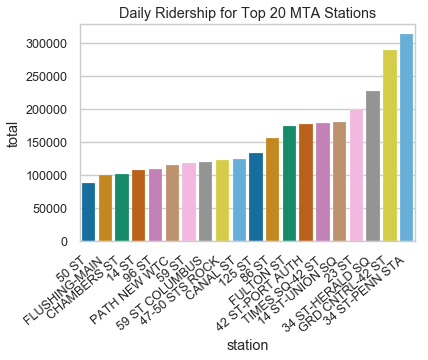

In [39]:
x=mta_diff_daily_median.tail(20).station
y=mta_diff_daily_median.tail(20).total
ax = sns.barplot(x,y, palette='colorblind')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Daily Ridership for Top 20 MTA Stations');
top_20 = list(mta_diff_daily_median.tail(20).station)
top_20

In [40]:
fig = ax.get_figure()
fig.savefig('Daily Ridership for Top 20 MTA Stations', frameon=True, ext='png', bbox_inches="tight")

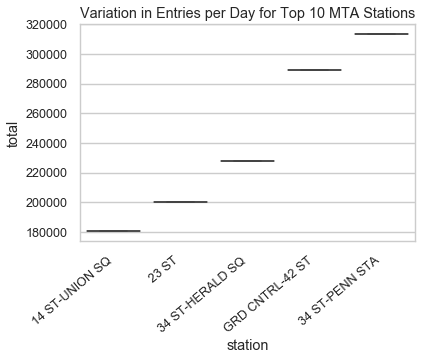

In [41]:
top10 = mta_diff_daily_median.tail()
ax = sns.boxplot(x=top10.station, y=top10.total, data=top10, showfliers=True, palette='bright') # make the plot 5 units high  
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Variation in Entries per Day for Top 10 MTA Stations');

From common knowledge, the results make sense, i.e., Time Square - 42nd st, Grand Central station, and Penn Station are usually heavily trafficked at any given day. Now it is time to optimize the time to organize the campaign - Let us compare the different months of interest, to decide which month to hold the campaign

## Arriving at the month to organize the campaign

In [42]:
mask1 = ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) > (pd.to_datetime('2019-01-01', format='%Y/%m/%d'))) & \
        ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) < (pd.to_datetime('2019-01-31', format='%Y/%m/%d'))) 
mask2 = ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) > (pd.to_datetime('2019-02-01', format='%Y/%m/%d'))) & \
        ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) < (pd.to_datetime('2019-02-28', format='%Y/%m/%d'))) 
mask3 = ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) > (pd.to_datetime('2019-03-01', format='%Y/%m/%d'))) & \
        ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) < (pd.to_datetime('2019-03-31', format='%Y/%m/%d'))) 
mask4 = ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) > (pd.to_datetime('2020-01-01', format='%Y/%m/%d'))) & \
        ((pd.to_datetime(mta_diff.date, format='%Y/%m/%d')) < (pd.to_datetime('2020-01-31', format='%Y/%m/%d'))) 

In [43]:
mta_jan2019_df = mta_diff[mask1]
mta_feb2019_df = mta_diff[mask2]
mta_mar2019_df = mta_diff[mask3]
mta_jan2020_df = mta_diff[mask4]

In [44]:
mta_jan2019_daily = pd.DataFrame(mta_jan2019_df.groupby(['station', 'date']).sum().reset_index())
mta_jan2019_median = mta_jan2019_daily.groupby('station').median().reset_index()
mta_jan2019_median = mta_jan2019_median.sort_values('total')
mta_jan2019_median_top5 = mta_jan2019_median.tail().total.sum()
print('Total ridership for Jan 2019 - ',mta_jan2019_median.tail().total.sum())

top10_jan2019 = mta_jan2019_median.tail(10)
mta_jan2019_median.tail()

Total ridership for Jan 2019 -  1199939.0


,station,entries,exits,ent,ext,total
352,TIMES SQ-42 ST,35141430542.000,27432998898.000,94303.000,83526.000,178882.000
46,23 ST,40227766040.000,44603101809.000,111123.000,83759.000,196850.000
59,34 ST-HERALD SQ,27627754476.000,34566140141.000,119650.000,104948.000,224899.000
233,GRD CNTRL-42 ST,13808619836.000,10210065516.000,152781.000,136649.000,289407.000
61,34 ST-PENN STA,23119464722.000,24440960419.000,164696.000,143994.000,309901.000


In [45]:
mta_feb2019_daily = pd.DataFrame(mta_feb2019_df.groupby(['station', 'date']).sum().reset_index())
mta_feb2019_median = mta_feb2019_daily.groupby('station').median().reset_index()
mta_feb2019_median = mta_feb2019_median.sort_values('total')
mta_feb2019_median_top5 = mta_feb2019_median.tail().total.sum()
print('Total ridership for Feb 2019 - ',mta_feb2019_median.tail().total.sum())
top10_feb2019 = mta_feb2019_median.tail()
mta_feb2019_median.tail()

Total ridership for Feb 2019 -  1207663.5


,station,entries,exits,ent,ext,total
14,14 ST-UNION SQ,5015818855.500,1863730202.000,92726.000,86666.500,178822.000
46,23 ST,40114299901.000,44335631691.500,115832.500,85251.500,201400.000
59,34 ST-HERALD SQ,27643613112.500,34582791951.000,118327.000,105230.500,222468.500
233,GRD CNTRL-42 ST,13819894019.500,10226339632.000,151276.500,133938.500,285572.500
61,34 ST-PENN STA,23130758998.000,24450270671.000,168419.000,149168.500,319400.500


In [46]:
mta_mar2019_daily = pd.DataFrame(mta_mar2019_df.groupby(['station', 'date']).sum().reset_index())
mta_mar2019_median = mta_mar2019_daily.groupby('station').median().reset_index()
mta_mar2019_median = mta_mar2019_median.sort_values('total')
mta_mar2019_median_top5 = mta_mar2019_median.tail().total.sum()
print('Total ridership for Mar 2019 - ',mta_mar2019_median.tail().total.sum())
mta_mar2019_median.tail()

Total ridership for Mar 2019 -  1282152.0


,station,entries,exits,ent,ext,total
14,14 ST-UNION SQ,5718487157.500,2246337303.500,104074.500,94105.500,198927.000
46,23 ST,39675078436.000,43186668810.500,122397.000,88958.500,210590.500
59,34 ST-HERALD SQ,27660264263.000,34600511518.500,127541.000,115311.500,242706.000
233,GRD CNTRL-42 ST,13820397110.500,10196237546.000,157625.500,141717.500,299064.000
61,34 ST-PENN STA,23032617153.500,24291724674.000,173609.500,156778.500,330864.500


In [47]:
mta_jan2020_daily = pd.DataFrame(mta_jan2020_df.groupby(['station', 'date']).sum().reset_index())
mta_jan2020_median = mta_jan2020_daily.groupby('station').median().reset_index()
mta_jan2020_median = mta_jan2020_median.sort_values('total')
mta_jan2020_median_top5 = mta_jan2020_median.tail().total.sum()
print('Total ridership for Jan 2020 - ',mta_jan2020_median.tail().total.sum())
mta_jan2020_median.tail()

Total ridership for Jan 2020 -  1200686.0


,station,entries,exits,ent,ext,total
68,42 ST-PORT AUTH,45180405252,37369932981,96724.000,82006.000,179852.000
46,23 ST,32941097509,29472965086,112873.000,87093.000,200042.000
59,34 ST-HERALD SQ,27044469258,34618513381,117661.000,110170.000,229886.000
233,GRD CNTRL-42 ST,15217051664,20554151250,141674.000,139690.000,282006.000
61,34 ST-PENN STA,22380414842,24339565963,158548.000,152369.000,308900.000


In [48]:
mta_jan2019_daily['month']='Jan-2019'
mta_feb2019_daily['month']='Feb-2019'
mta_mar2019_daily['month']='Mar-2019'
mta_jan2020_daily['month']='Jan-2020'
mta_daily = pd.concat([mta_jan2019_daily, mta_feb2019_daily, 
                       mta_mar2019_daily, mta_jan2020_daily], axis=0, ignore_index=True)

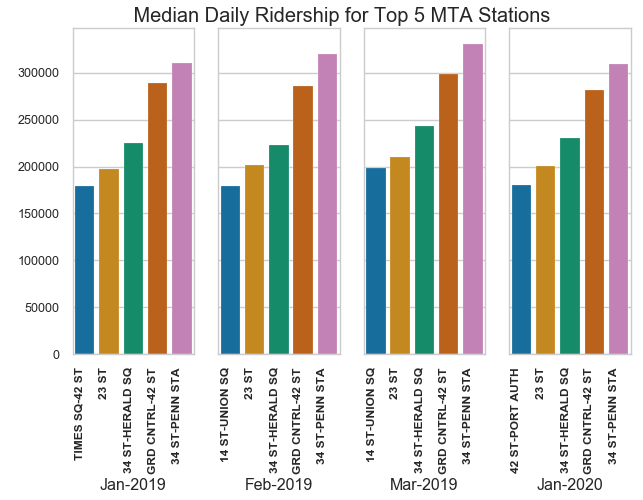

In [49]:
lst = ['Jan-2019', 'Feb-2019', 'Mar-2019', 'Jan-2020']
x0=mta_jan2019_median.tail().station
x4=mta_jan2020_median.tail().station
x=mta_diff_daily_median.tail().station
y_jan2019=mta_jan2019_median.tail().total
y_feb2019=mta_feb2019_median.tail().total
y_mar2019=mta_mar2019_median.tail().total
y_jan2020=mta_jan2020_median.tail().total
sns.set_style("whitegrid")
f, axes = plt.subplots(1, 4, sharey=True)
f.set_size_inches(10, 6)
ax = sns.barplot(x0,y_jan2019, palette='colorblind', ax=axes[0])
ax = sns.barplot(x,y_feb2019, palette='colorblind', ax=axes[1])
ax.set_title('                       Median Daily Ridership for Top 5 MTA Stations', fontsize=20, loc='center')
ax = sns.barplot(x,y_mar2019, palette='colorblind', ax=axes[2])
ax = sns.barplot(x4,y_jan2020, palette='colorblind', ax=axes[3])
for i in range(4):
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="right", fontsize=12, weight='bold')
    axes[i].set_xlabel(lst[i], ha="center", fontsize=16)
    axes[i].set_ylabel('', ha="center", fontsize=16)

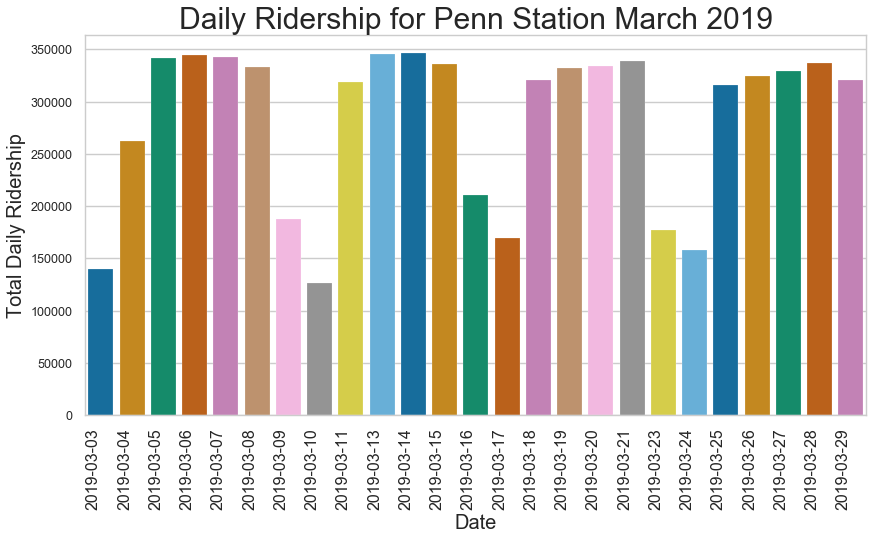

In [50]:
mask_station = (mta_mar2019_daily['station']=='34 ST-PENN STA') & \
                (mta_mar2019_daily['total']>100) & (mta_mar2019_daily['total']<400000)

penn = (mta_mar2019_daily[mask_station])
penn = penn.sort_values(['date'])
penn.head(5)
plt.figure(figsize=(14,7))
ax1 = sns.barplot(penn.date, penn.total, palette='colorblind');
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=16, ha="right")
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Total Daily Ridership', fontsize=20)
ax1.set_title('Daily Ridership for Penn Station March 2019', fontsize=30);

## Narrowing down on the day of the week for the top five stations:

In [51]:
mta_diff_daily.head()

,station,date,entries,exits,ent,ext,total
0,1 AV,2018-12-29,15205296880,8146820790,12071.000,15430.000,27501.000
1,1 AV,2018-12-30,18246428678,9776274598,11989.000,14775.000,26764.000
2,1 AV,2018-12-31,18246506588,9776371949,14786.000,18246.000,33032.000
3,1 AV,2019-01-01,18246586340,9776469526,9989.000,12097.000,22086.000
4,1 AV,2019-01-02,18246665311,9776564572,18476.000,21058.000,39534.000


We can see a clear pattern on the ridership. 
It could be due to the fact that people commuting to work on weekdays cause the higher ridership on weekdays.

In [52]:
type(mta_diff.loc[5, 'date'])

str

In [55]:
# Format Week and Day information 
def add_day_type_weekday_weekend(mta_diff):
    from datetime import datetime as dt
    weekend = ['Saturday', 'Sunday']
    mta_diff['day_name'] = pd.to_datetime(mta_diff['date']).dt.day_name()
    mta_diff['day_type'] = mta_diff.day_name.apply(lambda x: 'weekend' if x in weekend else 'weekday')
    return mta_diff

In [56]:
mta_wkday_type = add_day_type_weekday_weekend(mta_diff)
mta_wkday_type.head()

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,ent,ext,total,day_name,day_type
3668177,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2020-01-31,20:00:00,REGULAR,5554,420,0.000,0.000,0.000,Friday,weekday
2012853,R526,R096,00-03-02,82 ST-JACKSON H,7,IRT,2019-03-02,07:00:00,REGULAR,1725444,985514,0.000,0.000,0.000,Saturday,weekend
2012855,R526,R096,00-03-02,82 ST-JACKSON H,7,IRT,2019-03-02,15:00:00,REGULAR,1725444,985518,0.000,0.000,0.000,Saturday,weekend
2012856,R526,R096,00-03-02,82 ST-JACKSON H,7,IRT,2019-03-02,19:00:00,REGULAR,1725444,985518,0.000,0.000,0.000,Saturday,weekend
2012857,R526,R096,00-03-02,82 ST-JACKSON H,7,IRT,2019-03-02,23:00:00,REGULAR,1725444,985518,0.000,0.000,0.000,Saturday,weekend


In [57]:
mta_station_daily = mta_wkday_type.groupby(['station','date','day_type'])\
                    .median().reset_index().sort_values("total", ascending=False).copy()
                    

wkday_commute_analysis = mta_station_daily.groupby(['station', 'day_type'])\
                        .mean().reset_index().sort_values("total", ascending=False)

wkday_commute_analysis.head(6)

,station,day_type,entries,exits,ent,ext,total
574,MYRTLE AV,weekday,12263010.706,4630446.461,485.467,153.694,698.706
606,NEWKIRK PLAZA,weekday,9330993.128,10359187.967,309.911,232.294,688.067
752,YORK ST,weekday,15169087.506,7144472.572,449.539,81.161,680.528
74,191 ST,weekday,2228791.533,2584268.994,257.372,271.039,646.267
248,ASTORIA DITMARS,weekday,5031557.561,2554374.294,252.389,153.356,634.950
490,HOYT-SCHER,weekday,5855709.478,7456615.683,308.856,259.217,634.350


In [58]:
wkday_wkend_df = wkday_commute_analysis.pivot('station','day_type','total').reset_index()
wkday_wkend_df['total']=wkday_wkend_df.weekday + wkday_wkend_df.weekend
wkday_wkend_df.head()

day_type,station,weekday,weekend,total
0,1 AV,492.439,131.097,623.536
1,103 ST,508.022,316.625,824.647
2,103 ST-CORONA,572.283,398.139,970.422
3,104 ST,95.856,26.028,121.883
4,110 ST,519.689,324.375,844.064


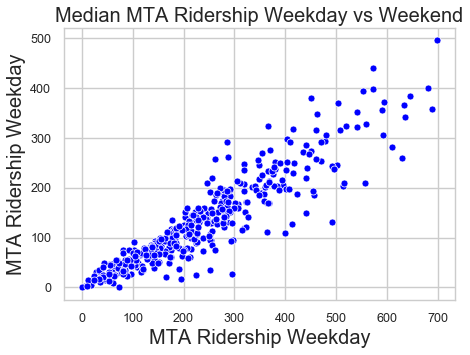

In [59]:
%matplotlib inline
plt.figure(figsize=(7,5))
ax = sns.scatterplot(wkday_wkend_df.weekday, wkday_wkend_df.weekend, markers=True, color='blue')
ax.set_title('Average Daily Volume by Station');
ax.set_title('Median MTA Ridership Weekday vs Weekend', fontsize=20);
ax.set_xlabel('MTA Ridership Weekday', fontsize=20)
ax.set_ylabel('MTA Ridership Weekday', fontsize=20);

In [62]:
mask_top20 = (mta_diff.station.isin(top_20))
mta_top20 = mta_diff[mask_top20]
mta_top20_wk_day_type = add_day_type_weekday_weekend(mta_top20)

mta_top20_daily = mta_top20_wk_day_type.groupby(['station','date','day_type'])\
                    .median().reset_index().sort_values("total", ascending=False).copy()

#chk for even weekday-weekend pairs for each of the top 20 stations. total should be 40.
mta_top20_grp = mta_top20_daily.groupby(['station','day_type']).count().reset_index()
mta_top20_grp.nunique()

mta_top20_wkday_analysis = mta_top20_daily.groupby(['station', 'day_type'])\
                        .mean().reset_index().sort_values("total", ascending=False)

top20_wkday_commute_analysis=mta_top20_wkday_analysis.drop(columns=['entries', 'exits', 'ent', 'ext']).head(6)
top20_wkday_commute_analysis = mta_top20_wkday_analysis.pivot('station','day_type','total').reset_index()
top20_wkday_commute_analysis['total']=top20_wkday_commute_analysis.weekday + top20_wkday_commute_analysis.weekend
top20_wkday_commute_analysis.head()

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


day_type,station,weekday,weekend,total
0,125 ST,434.917,271.167,706.083
1,14 ST,276.389,174.167,450.556
2,14 ST-UNION SQ,589.683,355.361,945.044
3,23 ST,318.361,119.139,437.500
4,34 ST-HERALD SQ,450.083,273.569,723.653


In [63]:
top20_wkday_commute_analysis.head()

day_type,station,weekday,weekend,total
0,125 ST,434.917,271.167,706.083
1,14 ST,276.389,174.167,450.556
2,14 ST-UNION SQ,589.683,355.361,945.044
3,23 ST,318.361,119.139,437.500
4,34 ST-HERALD SQ,450.083,273.569,723.653


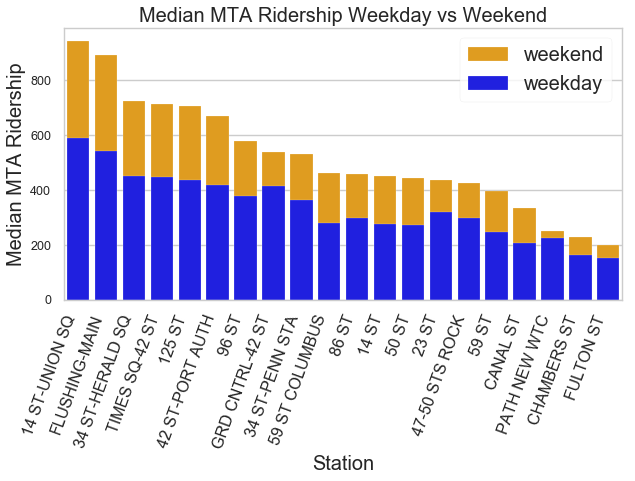

In [64]:
top20_wkday_analysis = top20_wkday_commute_analysis.sort_values('total', ascending=False).head(20)
plt.figure(figsize=(10,5))
ax2 = sns.barplot(top20_wkday_analysis.station, top20_wkday_analysis.total, color='orange', label='weekend')
ax1 = sns.barplot(top20_wkday_analysis.station, top20_wkday_analysis.weekday, color='blue', label='weekday');
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70, fontsize=16, ha="right")
ax1.set_title('Median MTA Ridership Weekday vs Weekend', fontsize=20);
ax1.set_xlabel('Station', fontsize=20)
ax1.set_ylabel('Median MTA Ridership', fontsize=20)
plt.legend(fontsize=20);

In [65]:
top20_wkday_analysis['ratio']=top20_wkday_analysis.weekday / top20_wkday_analysis.weekend
top20_wkday_analysis = top20_wkday_analysis.sort_values('ratio', ascending=False).reset_index()
top20_wkday_analysis.head()

day_type,index,station,weekday,weekend,total,ratio
0,18,PATH NEW WTC,223.911,25.597,249.508,8.747
1,17,GRD CNTRL-42 ST,412.872,126.708,539.581,3.258
2,16,FULTON ST,150.472,48.194,198.667,3.122
3,3,23 ST,318.361,119.139,437.500,2.672
4,14,CHAMBERS ST,163.067,66.681,229.747,2.445


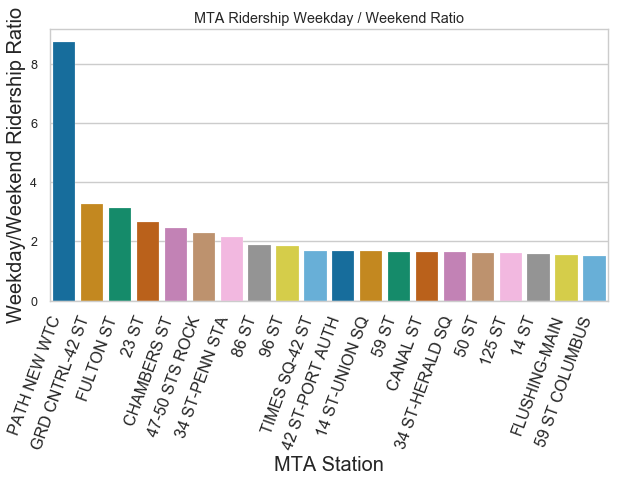

In [66]:
plt.figure(figsize=(10,5))
ax = sns.barplot(top20_wkday_analysis.station, top20_wkday_analysis.ratio, palette='colorblind')
ax.set_title('MTA Ridership Weekday / Weekend Ratio');
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, fontsize=16, ha="right")
ax.set_xlabel('MTA Station', fontsize=20)
ax.set_ylabel('Weekday/Weekend Ridership Ratio', fontsize=20);

## MTA Stations close to Tech Companies of NYC

In [67]:
top_tech_firms = {'Slack': '436 Lafayette St, New York, NY 10003', 
                  '2U': '55 Prospect St., Brooklyn, NY 11201',
                  'Compass': '90 Fifth Avenue, New York, NY 10011',
                  'Adobe':'1540 Broadway, New York, NY 10036',
                  'Square': '375 W Broadway, New York, NY 10012',
                  'Facebook': '770 Broadway, New York, NY 10003',
                  'Twitter': '249 W 17th St, New York, NY 10011',
                  'Google': '111 8th Ave, New York, NY 10011',
                  'Salesforce': '1095 Avenue of the Americas, New York, NY 10036',
                  'Amazon': '450 West 33rd Street, New York, NY 10001',
                  'Dashlane': '156 5th Ave, New York, NY 10010',
                  'TransferWise': '19 W 24th Street, New York, NY 10010',
                  'Teachers Pay Teachers': '101 6th Ave, New York, NY 10013',
                  'SevenRooms': '122 W. 27th Street, New York, NY 10001',
                  'SeatGeek': '400 Lafayette St, New York, NY 10003, US',
                  'TrialSpark': '45 W 27th St., New York, NY 10001',
                  'Genius':'92 3rd Street, Brooklyn, NY 11231',
                  'Skillshare': '35 E 21st St, New York, NY 10010',
                  'Greenhouse': '18 W 18th St, New York, NY 10011',
                  'Reaktor': '30 W 21st St, New York, NY 10010',
                  'Asana':'150 Greenwich St., New York, NY 10007',
                  'Stash':'500 7th Ave, New York, 10018, US',
                  'Honest Building': '115 Broadway, New York, NY 10006',
                  'Better Cloud': '101 6th Ave, New York, NY 10013',
                  'TripleLift': '400 Lafayette St, New York, NY 10003',
                  'Reonomy': '767 3rd Ave, New York, NY 10017',
                  'Updater':'19 Union Square West, New York, NY 10003',
                  'Teachable': '6 W 22nd St, New York, NY 10010',
                  'White Ops': '7 W 22nd Street, New York, NY 10010'}

In [6]:
top_tech_firms_df = pd.DataFrame(data=top_tech_firms.items(), index=None, columns = ['Company', 'Address'])

In [7]:
top_tech_firms_df.head()

,Company,Address
0,Slack,"436 Lafayette St, New York, NY 10003"
1,2U,"55 Prospect St., Brooklyn, NY 11201"
2,Compass,"90 Fifth Avenue, New York, NY 10011"
3,Adobe,"1540 Broadway, New York, NY 10036"
4,Square,"375 W Broadway, New York, NY 10012"


In [145]:
import geopy.geocoders
from geopy.geocoders import Nominatim
geopy.geocoders.options.default_user_agent = 'Metis MTA Project 1'
geopy.geocoders.options.default_timeout = 15
geolocator = Nominatim()

def add_coords(dataframe):
    '''
    Accepts dataframe of location data with address column,
    Adds 2 new float columns to dataframe with latitude and longitude coordinates
    for later use in folium map
    
    Relies on geopy geocode information
    Geopy returns 2 cols:
        0: str containing descriptive data related to address
        1: tuple containing latitude and longitude as floats
    
    '''
    lat,lon = [],[]
    for i in range(len(dataframe)):
        location = geolocator.geocode(dataframe['Address'][i])
        lat.append(location[-1][0])
        lon.append(location[-1][1])

    dataframe['latitude'] = lat
    dataframe['longitude'] = lon
    return dataframe

In [146]:
ttf_df = add_coords(top_tech_firms_df)
ttf_df

,Company,Address,Latitude,Longitude,latitude,longitude
0,Slack,"436 Lafayette St, New York, NY 10003",40.729,-73.992,40.729,-73.992
1,2U,"55 Prospect St., Brooklyn, NY 11201",40.701,-73.988,40.701,-73.988
2,Compass,"90 Fifth Avenue, New York, NY 10011",42.983,-78.710,42.983,-78.710
3,Adobe,"1540 Broadway, New York, NY 10036",40.758,-73.985,40.758,-73.985
4,Square,"375 W Broadway, New York, NY 10012",40.724,-74.003,40.724,-74.003
5,Facebook,"770 Broadway, New York, NY 10003",40.731,-73.992,40.731,-73.992
6,Twitter,"249 W 17th St, New York, NY 10011",40.741,-74.000,40.741,-74.000
7,Google,"111 8th Ave, New York, NY 10011",40.742,-74.004,40.742,-74.004
8,Salesforce,"1095 Avenue of the Americas, New York, NY 10036",40.755,-73.985,40.755,-73.985
9,Amazon,"450 West 33rd Street, New York, NY 10001",40.754,-73.999,40.754,-73.999


In [147]:
mta_loc_data = pd.read_csv('MTA_address.csv')
mta_loc_data.head()
mta_loc_data.columns
cols = ['NAME', 'the_geom']
mta_loc_data =mta_loc_data[cols]

In [148]:
cols = mta_loc_data.columns
cols = [x.strip().lower() for x in cols]
mta_loc_data.head()

,NAME,the_geom
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978)
1,Canal St,POINT (-74.00019299927328 40.71880300107709)
2,50th St,POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568)


In [149]:
mask_top20 = (mta_loc_data.NAME.isin(top_20))
top20_mta_loc = mta_loc_data[mask_top20]

In [150]:
top20_mta_loc.head()

,NAME,the_geom


In [151]:
top_20

['50 ST',
 'FLUSHING-MAIN',
 'CHAMBERS ST',
 '14 ST',
 '96 ST',
 'PATH NEW WTC',
 '59 ST',
 '59 ST COLUMBUS',
 '47-50 STS ROCK',
 'CANAL ST',
 '125 ST',
 '86 ST',
 'FULTON ST',
 '42 ST-PORT AUTH',
 'TIMES SQ-42 ST',
 '14 ST-UNION SQ',
 '23 ST',
 '34 ST-HERALD SQ',
 'GRD CNTRL-42 ST',
 '34 ST-PENN STA']

In [177]:
station_address = {'50 ST':'New York, NY 10019',
                  'FLUSHING-MAIN':'Queens, NY 11354',
                  'CHAMBERS ST':'New York, NY 10013',
                  '14 ST': 'New York, NY 10009',
                    '96 ST':'New York, NY 10025',
                  'PATH NEW WTC': 'New York, NY 10007',
                   '59 ST':'Brooklyn, NY 11234',
                   '59 ST COLUMBUS':'Columbus Cir, New York, NY 10023',
                   '47-50 STS ROCK':'New York, NY 10020',
                   'CANAL ST':'New York, NY 10013',
                   '125 ST':'New York, NY 10027',
                   '86 ST':'350 East 86th St, New York, NY 10028',
                   'FULTON ST':'New York, NY 10038',
                   '42 ST-PORT AUTH':'8th Ave, New York, NY 07094',
                   'TIMES SQ-42 ST': 'New York, NY 10018',
                  '14 ST-UNION SQ': 'New York, NY 10003',
                  '23 ST':'E 23rd St, New York, NY 10010',
                  '34 ST-HERALD SQ':'New York, NY 10001',
                  'GRD CNTRL-42 ST':'New York, NY 10017',
                  '34 ST-PENN STA':'New York, NY 10120'}
station_address_df = pd.DataFrame(data=station_address.items(), index=None, columns = ['station', 'Address'])
station_address_df.head(20)

,station,Address
0,50 ST,"New York, NY 10019"
1,FLUSHING-MAIN,"Queens, NY 11354"
2,CHAMBERS ST,"New York, NY 10013"
3,14 ST,"New York, NY 10009"
4,96 ST,"New York, NY 10025"
5,PATH NEW WTC,"New York, NY 10007"
6,59 ST,"Brooklyn, NY 11234"
7,59 ST COLUMBUS,"Columbus Cir, New York, NY 10023"
8,47-50 STS ROCK,"New York, NY 10020"
9,CANAL ST,"New York, NY 10013"


In [178]:
top20_df = add_coords(station_address_df)
top20_df

,station,Address,latitude,longitude
0,50 ST,"New York, NY 10019",40.741,-73.357
1,FLUSHING-MAIN,"Queens, NY 11354",40.750,-73.798
2,CHAMBERS ST,"New York, NY 10013",40.713,-74.006
3,14 ST,"New York, NY 10009",40.713,-74.006
4,96 ST,"New York, NY 10025",40.741,-73.357
5,PATH NEW WTC,"New York, NY 10007",40.713,-74.006
6,59 ST,"Brooklyn, NY 11234",40.650,-73.950
7,59 ST COLUMBUS,"Columbus Cir, New York, NY 10023",40.768,-73.982
8,47-50 STS ROCK,"New York, NY 10020",40.741,-73.357
9,CANAL ST,"New York, NY 10013",40.713,-74.006


In [179]:
top20_df_full = pd.merge(top20_df, top20_wkday_commute_analysis, on='station')
top20_df_full.head(20)
top20_df_full['total'] = top20_df_full['total']/1000
top20_df_full.head()

,station,Address,latitude,longitude,weekday,weekend,total
0,50 ST,"New York, NY 10019",40.741,-73.357,273.739,169.444,0.443
1,FLUSHING-MAIN,"Queens, NY 11354",40.750,-73.798,540.844,351.556,0.892
2,CHAMBERS ST,"New York, NY 10013",40.713,-74.006,163.067,66.681,0.230
3,14 ST,"New York, NY 10009",40.713,-74.006,276.389,174.167,0.451
4,96 ST,"New York, NY 10025",40.741,-73.357,377.011,202.889,0.580


In [180]:
address = 'Manhattan, New York City, New York, USA'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of NYC are {}, {}.'.format(latitude, longitude))

The geographical coordinate of NYC are 40.7896239, -73.9598939.


In [190]:
# Creating a map using latitude and longitude values
from folium.plugins import HeatMap
NewYorkMap = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Company in zip(ttf_df['Latitude'], ttf_df['Longitude'], ttf_df['Company']):
    label = '{}'.format(Company)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NewYorkMap)  

# convert to (n, 2) nd-array format for heatmap
stationArr = top20_df_full[['latitude', 'longitude', 'total']].as_matrix()

# plot heatmap
NewYorkMap.add_children(HeatMap(stationArr, radius=10, blur=3, gradient={1: 'red'}, control=False))   
NewYorkMap

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [173]:
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):
    """Creates a map given a dataframe of points. Can also produce a heatmap overlay

    Arg:
        df: dataframe containing points to maps
        lat_col: Column containing latitude (string)
        lon_col: Column containing longitude (string)
        zoom_start: Integer representing the initial zoom of the map
        plot_points: Add points to map (boolean)
        pt_radius: Size of each point
        draw_heatmap: Add heatmap to map (boolean)
        heat_map_weights_col: Column containing heatmap weights
        heat_map_weights_normalize: Normalize heatmap weights (boolean)
        heat_map_radius: Size of heatmap point

    Returns:
        folium map object
    """

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['name'],
                                fill_color="#3db7e4", # divvy color
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        # convert to (n, 2) or (n, 3) matrix format
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            # if we have to normalize
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].as_matrix()
        curr_map.add_children(HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [174]:
map_points(top20_df_full, plot_points=False, draw_heatmap=True,
           heat_map_weights_normalize=False, 
           heat_map_weights_col='total', heat_map_radius=9)

/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
